In [1]:
import glob
import netCDF4
from netCDF4 import Dataset 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap 
from IPython.core.display import HTML
HTML( open('my_css.css').read() ) # if you don't have my_css.css, comment this line out

In [2]:
# http://matplotlib.org/users/customizing.html
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

# Elementary time-series  analysis of the PDSI

v1.1, 27 August 2016, by Brian Fiedler

We will explore some time-series data of the Palmer Drought Severity Index (PDSI).  Our analysis is not great:
we will just use numpy to examine how drought is correlated around the globe (correlation) and how it is correlated with itself in time (autocorrelation). 

Learn about the PDSI:

 * The PDSI is also referred to as just the [PDI, or Palmer drought index](https://en.wikipedia.org/wiki/Palmer_drought_index)

 * [North American Drought: a Paleo Perspective](http://www.ncdc.noaa.gov/paleo/drought/drght_history.html)

 * [Paths to more data](https://climatedataguide.ucar.edu/climate-data/palmer-drought-severity-index-pdsi)

You will need this file: [pdsi.mon.mean.nc](https://anaconda.org/bfiedler/data/1/download/pdsi.mon.mean.nc). It is also available [from ESRL](http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/dai_pdsi/catalog.html?dataset=Datasets/dai_pdsi/pdsi.mon.mean.nc).  I cannot vouch whether this dataset is the best available. It does provide some exercise with time-series analysis.

We also enjoy some plotting and analysis of time-series of a single variables, in very simple short netCDF files. 

For that, you will need these files too: [knmi.zip](https://anaconda.org/bfiedler/data/1/download/knmi.zip)

**Your student [Student Tasks](#Student-Tasks) are below.**

# Some helpful functions 

In [3]:
def ncsummary(ncf): # prints a summary of the contents of netCDF file
    for item in ncf.ncattrs():
        print(item,': ',ncf.getncattr(item))

    print() #blank line
    for  key in list(ncf.dimensions.keys()):
        print(ncf.dimensions[key])
    
    for  key in list(ncf.variables.keys()):
        print(ncf.variables[key])

In [4]:
def time2years(tvals,nc_time_units):
    # nc_time_units could be like so: "months since 1958-01-01"
    ts=nc_time_units.split() # splits at white space, into a list
    startdate=ts[2] # ts[-1] could be 1958-01-01
    year,month,day=startdate.split('-') # could be strings: 1958, 01, 01
    if ts[0]=='months':
        fs=12.
    elif ts[0]=='hours':
        fs=8766.
    elif ts[0]=='days':
        fs=365.25
    elif ts[0]=='years':
        fs=1.
    else:
        sys.exit(ts[0]+' not allowed')
    return tvals/fs + float(year) # always plot time axis in years

In [5]:
def time_series_plot(times,vals,title="",xlab="",ylab="",comment="",negc='blue',posc='red'):
    fig = plt.figure(figsize=(16,4),facecolor='white')  
    ax1 = fig.add_axes([0.05,0.2,0.9,.7])  
    ax1.fill_between(times,vals,y2=0,where=vals>0,color=posc) # filled plot
    ax1.fill_between(times,vals,y2=0,where=vals<0,color=negc) # filled plot
    ax1.grid() # show grid lines
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.set_xlim((times[0],times[-1]))
    dmin=vals.min()
    dmax=vals.max()
    if dmin>=0.:
        if dmin>.5*dmax:
            ax1.set_ylim(ymin=.98*dmin)
        else:
            ax1.set_ylim(ymin=0.0)
    ax1.set_title(title)
    ax1.text(0.01,-0.2,comment,fontsize=10,transform=ax1.transAxes)  
    plt.close(fig)
    return fig

In [6]:
def spectral_density_plot(times, vals, nfft=2048, title="",
                          unit="year", ylab="", comment=""):
    fig = plt.figure(figsize=(16,4),facecolor='white')  
    ax1 = fig.add_axes([0.05,0.2,0.9,.7]) 
    timesx = times[vals.mask == False] # take only unmasked values, may be unnecessary
    valsx = vals[vals.mask == False] # take only unmasked values, may be unnecessary
    dta = timesx[1:]-timesx[:-1]
    dtamin = dta.min()
    dtamax = dta.max()
    if not dtamin > .99*dtamax:
        print("trouble ahead, dt not uniform:", dtamin, dtamax)
    pf = np.polyfit(timesx,valsx,1) # best linear fit: data = pf[0]*tval+pf[1]
    valsd = valsx - pf[0]*timesx - pf[1] # detrended values
    ax1.psd(valsd, NFFT=nfft, Fs=1/dtamax) # dtamin should also work here
    ax1.set_ylabel(ylab)
    ax1.set_xlabel("frequency (cycles/"+unit+")")
    ax1.set_title( title+', Power Spectral Density from detrended data')
    ax1.text(0.01,-0.2,comment,fontsize=10,transform=ax1.transAxes)

# Choosing and plotting a KNMI file

You will need to unzip [knmi.zip](https://anaconda.org/bfiedler/data/1/download/knmi.zip), which contains small files of a time series of a single quantity.  There is a task for `knmi/ilabrijn.nc` , defined below with the other tasks.

In [7]:
files = glob.glob("knmi/*.nc")
for filename in files:
    ncf = Dataset(filename,'r')   
    print(filename,ncf.comment,"\n")


knmi/isunspots.nc  from <a href="http://sidc.oma.be/">SIDC</a> via the KNMI Climate Explorer (http://climexp.knmi.nl) 

knmi/ilabrijn.nc  the "Labrijn series" 1706-2000 by A.F.V. van Engelen and J.W. Nellestijn Monthly means of the airtemperature in De Bilt, Netherlands. Component observational series: Delft/Rijnsburg (1706-1734), Zwanenburg (1735-1800 & 1811-1848), Haarlem (1801-1810) and Utrec (c) Copyright KNMI De Bilt, Netherlands, 1995. via the KNMI Climate Explorer (http://climexp.knmi.nl) 

knmi/imaunaloa_f.nc  monthly CO2 concentrations measured at Mauna Loa from Scripps and <a href="http://www.esrl.noaa.gov/gmd/ccgg/trends/">ESRL</a> interpolated undefined anomalies linearly via the KNMI Climate Explorer (http://climexp.knmi.nl) 

knmi/ihadisst1_nino3.4a.nc  cutting out region lon= -170.000 -120.000, lat=   -5.000    5.000 plotdat anomal 1971 2000 hadisst1_nino3.4.dat cutting out region lon= -170.000 -120.000, lat=   -5.000    5.000 via the KNMI Climate Explorer (http://climex

In [8]:
#Select one:
inputfile = "knmi/imaunaloa_f.nc"
#inputfile = "knmi/isunspots.nc"
#inputfile = "knmi/ihadisst1_nino3.4a.nc"
#inputfile = "knmi/ilabrijn.nc"
ncf = Dataset(inputfile,'r') 
print(ncf)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Mauna Loa CO2
    comment:  monthly CO2 concentrations measured at Mauna Loa from Scripps and <a href="http://www.esrl.noaa.gov/gmd/ccgg/trends/">ESRL</a> interpolated undefined anomalies linearly via the KNMI Climate Explorer (http://climexp.knmi.nl)
    Conventions: CF-1.0
    history: 
written by writencseries (GJvO, KNMI) by 2016-08-24 21:51:19 bin/dat2nc data/imaunaloa_f.dat i Mauna_Loa_CO2 data/imaunaloa_f.nc
    dimensions(sizes): time(708)
    variables(dimensions): float32 time(time), float32 co2(time)
    groups: 



In [9]:
ncsummary(ncf) # my own summarizer function

title :  Mauna Loa CO2
comment :   monthly CO2 concentrations measured at Mauna Loa from Scripps and <a href="http://www.esrl.noaa.gov/gmd/ccgg/trends/">ESRL</a> interpolated undefined anomalies linearly via the KNMI Climate Explorer (http://climexp.knmi.nl)
Conventions :  CF-1.0
history :  
written by writencseries (GJvO, KNMI) by 2016-08-24 21:51:19 bin/dat2nc data/imaunaloa_f.dat i Mauna_Loa_CO2 data/imaunaloa_f.nc

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 708

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    units: months since 1958-01-15
    standard_name: time
    long_name: time
    axis: T
    calendar: gregorian
unlimited dimensions: 
current shape = (708,)
filling off

<class 'netCDF4._netCDF4.Variable'>
float32 co2(time)
    long_name: co2 concentration
    units: ppm
    _FillValue: 3e+33
unlimited dimensions: 
current shape = (708,)
filling off



In [10]:
#### get time array and data array:
if inputfile == "knmi/imaunaloa_f.nc":
    varname = 'co2'
if inputfile == "knmi/isunspots.nc":
    varname = 'sunspot'
if inputfile == "knmi/ihadisst1_nino3.4a.nc":
    varname = 'SST'
if inputfile == "knmi/ilabrijn.nc":
    varname = "tair"
tvals = ncf.variables['time'][:]
tunits = ncf.variables['time'].units
data = ncf.variables[varname][:] # data, to plot vs. time
title = ""
if 'title' in ncf.ncattrs(): title += ncf.getncattr('title')
try:
    long_name=ncf.variables[varname].long_name
except:
    long_name=varname
title += ", "+long_name
print(title)
units=ncf.variables[varname].units
print(units)

Mauna Loa CO2, co2 concentration
ppm


In [11]:
# Students: task modifications here
if inputfile == "knmi/ilabrijn.nc":
    pass

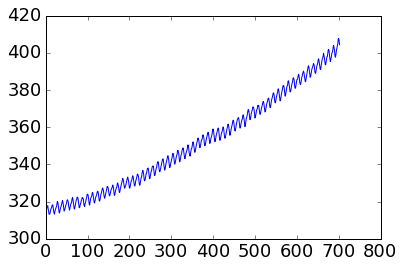

In [12]:
plt.plot(tvals,data); # quick look

In [13]:
print(tunits)

months since 1958-01-15


In [14]:
tvalys = time2years(tvals,tunits)

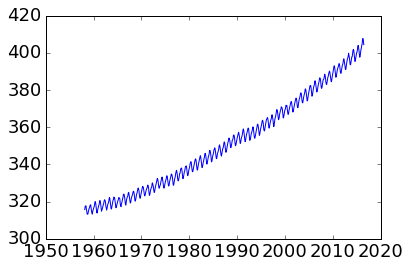

In [15]:
plt.plot(tvalys,data);

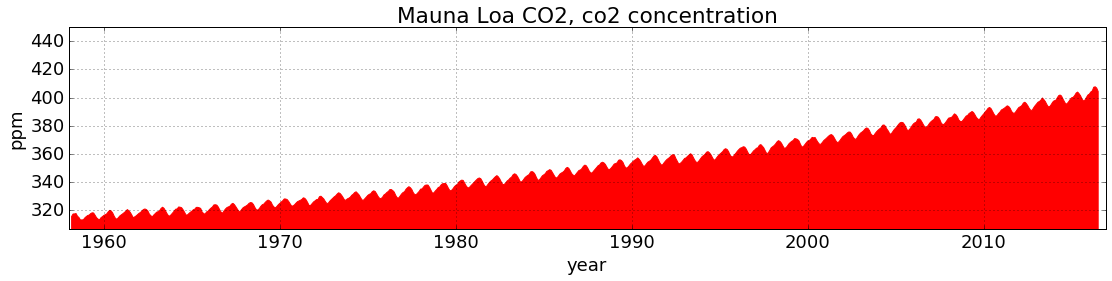

In [16]:
tsplot=time_series_plot(tvalys,data,title=title,ylab=units,xlab='year')
tsplot

In [17]:
fname = title.replace(' ','')
fname = fname.replace(',','')
outname = fname+'.png'
print("will save to:",outname)
tsplot.savefig(outname)

will save to: MaunaLoaCO2co2concentration.png


In [18]:
sum(data.mask) # spectral_density_plot will deal with this

7

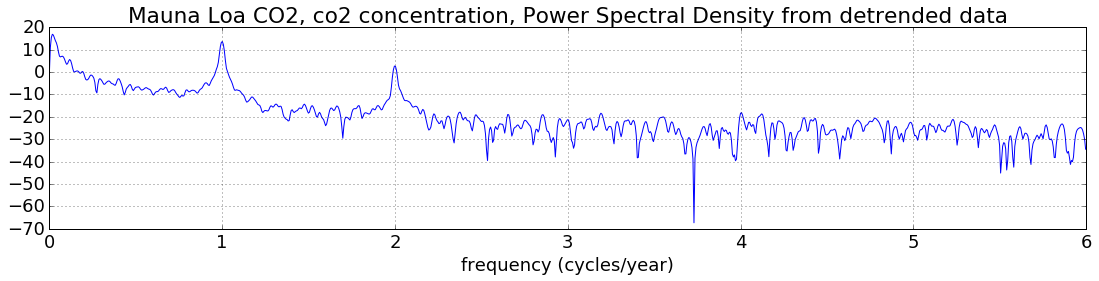

In [19]:
spectral_density_plot(tvalys,data,title=title)

# Plot the PDSI data



In [20]:
proj = 'cyl' # choose a map projection, lcc or cyl

## Pick a point for particular study
# Norman, Oklahoma:
pointlat = 35.329
pointlon = -97.274
where = "Norman OK"
# Toowoomba, Queensland, Australia:


In [21]:
ncf = Dataset('pdsi.mon.mean.nc')
print(ncf)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: Global Monthly Dai Palmer Drought Severity Index
    history: recreated Feb 2007 from data at NCAR webpage
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.pdsi.html
    original_source: NCAR/UCAR: A Dai.
    comments: This version of the dataset (1870-2005) supersedes the 1870-2003 version art PSD before Feb 2007
    Conventions: COARDS
    details: see ncar for more detials and updates
http://www.cgd.ucar.edu/cas/catalog/climind/pdsi.html
use reference Dai, A., K. E. Trenberth, and T. Qian, 2004: 
A global data set of Palmer Drought Severity Index for 1870-2002:
Relationship with soil moisture and effects of surface warming. 
J. Hydrometeorology, 5, 1117-1130.
    dataset_title: Palmer Drought Severity Index
    dimensions(sizes): lon(144), lat(55), time(1632)
    variables(dimensions): float32 pdsi(time,lat,lon), float32 lon(lon), float32 lat(lat), float64 time(t

In [22]:
ncsummary(ncf) # use my own summarizer function

title :  Global Monthly Dai Palmer Drought Severity Index
history :  recreated Feb 2007 from data at NCAR webpage
References :  http://www.esrl.noaa.gov/psd/data/gridded/data.pdsi.html
original_source :  NCAR/UCAR: A Dai.
comments :  This version of the dataset (1870-2005) supersedes the 1870-2003 version art PSD before Feb 2007
Conventions :  COARDS
details :  see ncar for more detials and updates
http://www.cgd.ucar.edu/cas/catalog/climind/pdsi.html
use reference Dai, A., K. E. Trenberth, and T. Qian, 2004: 
A global data set of Palmer Drought Severity Index for 1870-2002:
Relationship with soil moisture and effects of surface warming. 
J. Hydrometeorology, 5, 1117-1130.
dataset_title :  Palmer Drought Severity Index

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 55

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1632

<class 'netCDF4._netCDF4.Variable'>
float32 pdsi(time, lat, lon)


In [23]:
pdsi = ncf.variables['pdsi'][:]
print( pdsi.min(), pdsi.max() )

-14.9989 14.9999


In [24]:
lons = ncf.variables['lon'][:]
print(lons)

[-178.75 -176.25 -173.75 -171.25 -168.75 -166.25 -163.75 -161.25 -158.75
 -156.25 -153.75 -151.25 -148.75 -146.25 -143.75 -141.25 -138.75 -136.25
 -133.75 -131.25 -128.75 -126.25 -123.75 -121.25 -118.75 -116.25 -113.75
 -111.25 -108.75 -106.25 -103.75 -101.25  -98.75  -96.25  -93.75  -91.25
  -88.75  -86.25  -83.75  -81.25  -78.75  -76.25  -73.75  -71.25  -68.75
  -66.25  -63.75  -61.25  -58.75  -56.25  -53.75  -51.25  -48.75  -46.25
  -43.75  -41.25  -38.75  -36.25  -33.75  -31.25  -28.75  -26.25  -23.75
  -21.25  -18.75  -16.25  -13.75  -11.25   -8.75   -6.25   -3.75   -1.25
    1.25    3.75    6.25    8.75   11.25   13.75   16.25   18.75   21.25
   23.75   26.25   28.75   31.25   33.75   36.25   38.75   41.25   43.75
   46.25   48.75   51.25   53.75   56.25   58.75   61.25   63.75   66.25
   68.75   71.25   73.75   76.25   78.75   81.25   83.75   86.25   88.75
   91.25   93.75   96.25   98.75  101.25  103.75  106.25  108.75  111.25
  113.75  116.25  118.75  121.25  123.75  126.25  1

In [25]:
lats = ncf.variables['lat'][:]
print(lats)

[-58.75 -56.25 -53.75 -51.25 -48.75 -46.25 -43.75 -41.25 -38.75 -36.25
 -33.75 -31.25 -28.75 -26.25 -23.75 -21.25 -18.75 -16.25 -13.75 -11.25
  -8.75  -6.25  -3.75  -1.25   1.25   3.75   6.25   8.75  11.25  13.75
  16.25  18.75  21.25  23.75  26.25  28.75  31.25  33.75  36.25  38.75
  41.25  43.75  46.25  48.75  51.25  53.75  56.25  58.75  61.25  63.75
  66.25  68.75  71.25  73.75  76.25]


In [26]:
tvals = ncf.variables['time'][:]
tunits = ncf.variables['time'].units
print(tunits,tvals)

hours since 1800-01-01 00:00:0.0 [  613608.   614352.   615024. ...,  1803552.  1804296.  1805016.]


In [27]:
#http://stackoverflow.com/questions/37895666/how-to-calculate-hour-to-day-in-netcdf-file-using-scala
dates = netCDF4.num2date(tvals,tunits)
dates

array([datetime.datetime(1870, 1, 1, 0, 0),
       datetime.datetime(1870, 2, 1, 0, 0),
       datetime.datetime(1870, 3, 1, 0, 0), ...,
       datetime.datetime(2005, 10, 1, 0, 0),
       datetime.datetime(2005, 11, 1, 0, 0),
       datetime.datetime(2005, 12, 1, 0, 0)], dtype=object)

For plotting, I make `tvalys` as time in years, as a floating point number

In [28]:
tvalys = time2years(tvals,tunits) # I needs years as floating number for plotting

In [29]:
tvalys[0],tvalys[-1]

(1869.9986310746065, 2005.9110198494182)

For plotting with either `pcolor` or `pcolormesh`, we need the coordinates of the 4 points, in longitude and latitude, that surround a data value.
So we **extend** `lons` and `lats` to `lonsx` and `latsx`.

In [30]:
lonsx = np.zeros( lons.shape[0]+1 )
lonsx[1:-1] = (lons[1:]+lons[:-1])*0.5
lonsx[0] = lonsx[1] -(lonsx[2]-lonsx[1] )
lonsx[-1] = lonsx[-2] + (lonsx[-2]-lonsx[-3])
lonsx

array([-180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5,
       -160. , -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5,
       -140. , -137.5, -135. , -132.5, -130. , -127.5, -125. , -122.5,
       -120. , -117.5, -115. , -112.5, -110. , -107.5, -105. , -102.5,
       -100. ,  -97.5,  -95. ,  -92.5,  -90. ,  -87.5,  -85. ,  -82.5,
        -80. ,  -77.5,  -75. ,  -72.5,  -70. ,  -67.5,  -65. ,  -62.5,
        -60. ,  -57.5,  -55. ,  -52.5,  -50. ,  -47.5,  -45. ,  -42.5,
        -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,  -22.5,
        -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,   -2.5,
          0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,
         20. ,   22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,
         40. ,   42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,
         60. ,   62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,
         80. ,   82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,
      

In [31]:
latsx = np.zeros(lats.shape[0]+1)
latsx[1:-1] = (lats[1:]+lats[:-1])*0.5
latsx[0] = latsx[1] -(latsx[2]-latsx[1] )
latsx[-1] = latsx[-2] + (latsx[-2]-latsx[-3])
latsx

array([-60. , -57.5, -55. , -52.5, -50. , -47.5, -45. , -42.5, -40. ,
       -37.5, -35. , -32.5, -30. , -27.5, -25. , -22.5, -20. , -17.5,
       -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,
         7.5,  10. ,  12.5,  15. ,  17.5,  20. ,  22.5,  25. ,  27.5,
        30. ,  32.5,  35. ,  37.5,  40. ,  42.5,  45. ,  47.5,  50. ,
        52.5,  55. ,  57.5,  60. ,  62.5,  65. ,  67.5,  70. ,  72.5,
        75. ,  77.5])

In [32]:
lonsxa,latsxa = np.meshgrid(lonsx,latsx) 
print(lonsxa.shape, latsxa.shape, pdsi.shape)

(56, 145) (56, 145) (1632, 55, 144)


We also need "conventional" arrays of latitude and longitude at the center of the pixels.

In [33]:
lonsa,latsa = np.meshgrid(lons,lats) # makes 2-D arrays of same shape as pdsi 
print(lonsa.shape, latsa.shape, pdsi.shape)

(55, 144) (55, 144) (1632, 55, 144)


In [34]:
# the d2 distance^2 metric is only accurate for small distances, 
# which is okay because we seeking where the minimum im d2 is
d2 = (latsa - pointlat)**2 + np.cos(latsa*np.pi/180.)**2*(lonsa - pointlon)**2
print("where the min of d2 is in the flattened array:",np.argmin(d2))
pointlati, pointloni = np.unravel_index( np.argmin(d2), d2.shape ) # need to convert the flattened index

print("we see to study longitude", pointlon,", which is closest to longitude index", pointloni,
      ", which is at ",lonsa[pointlati,pointloni])
print("we see to study latitude", pointlat,", which is closest to latitude index", pointlati,
      ", which is at ",latsa[pointlati,pointloni])

where the min of d2 is in the flattened array: 5505
we see to study longitude -97.274 , which is closest to longitude index 33 , which is at  -96.25
we see to study latitude 35.329 , which is closest to latitude index 38 , which is at  36.25


Let's inspect one value of `pdsi`. If you have set `pointlat` and `pointlat` for Norman OK, we find that August 1956 was a time of severe drought.

In [35]:
tindex = 1039
tvalys[tindex]

1956.5776865160849

In [36]:
dates[tindex]

datetime.datetime(1956, 8, 1, 0, 0)

In [37]:
dates[tindex].strftime('%Y-%m-%d')

'1956-08-01'

In [38]:
pdsi[tindex,pointlati,pointloni]

-7.1381354

In [39]:
startlon=-180. # for this dataset, longitudes start at -180

if proj=='lcc': #Lambert Conformal
    m = Basemap(llcrnrlon=-145.5,llcrnrlat=1.,urcrnrlon=-2.566,urcrnrlat=46.352,\
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_1=50.,lon_0=-107.)
    parallels = np.arange(0.,80,20.)
    meridians = np.arange(10.,360.,30.)
else: #cylindrical is default
    m = Basemap(llcrnrlon=startlon,llcrnrlat=-90,urcrnrlon=startlon+360.,urcrnrlat=90.,\
            resolution='c',area_thresh=10000.,projection='cyl')
    parallels = np.arange(-90.,90.,30.)
    if startlon==-180:
        meridians = np.arange(-180.,180.,60.)
    else:
        meridians = np.arange(0.,360.,60.)
        
X,Y = m(lonsxa,latsxa) # Very important! For pcolormesh 

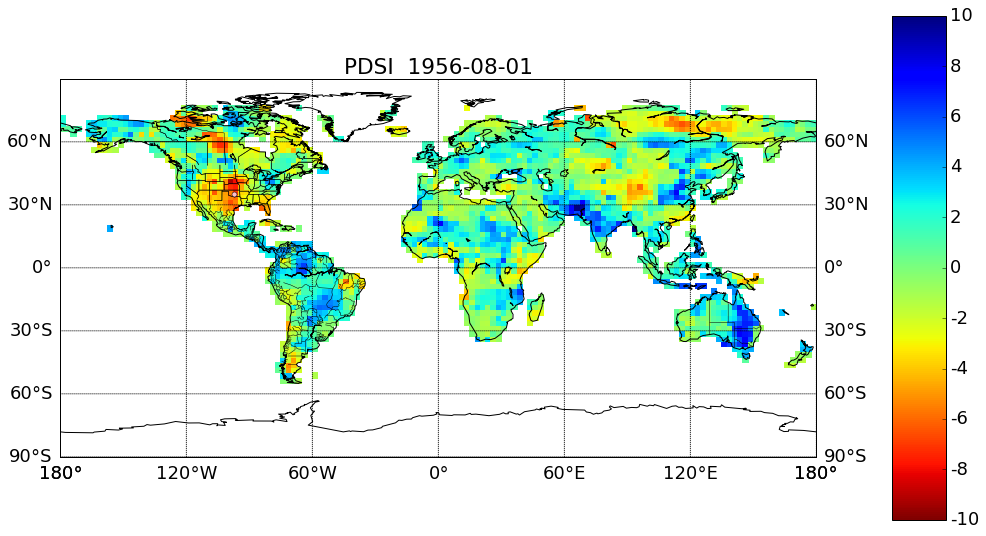

In [40]:
colormap = plt.cm.jet_r # _r means reverse, red will be negative, for drought
colorbounds=[-10,10] # numbers mapped to extremes of color map
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes( [0.08,0.1,0.7,0.7], axisbg='white' )

p = m.pcolormesh(X, Y, pdsi[tindex], cmap=colormap) 
when = dates[tindex].strftime('%Y-%m-%d')
ax.set_title("PDSI  "+when)

m.drawcoastlines()
m.drawstates()

im = plt.gci()
im.set_clim( vmin=colorbounds[0], vmax=colorbounds[1] )
cax = fig.add_axes( [0.85, 0.1, 0.05, 0.7] ) # setup colorbar axes
plt.colorbar(format='%d', cax=cax) # draw colorbar

plt.axes(ax)  # make the original axes current again

xpt,ypt=m(pointlon,pointlat) # make a pink dot here
m.plot([xpt],[ypt],'o',color='pink',markersize=5,zorder=2) 

m.drawparallels(parallels,labels=[1,1,0,1])
m.drawmeridians(meridians,labels=[1,1,0,1]);

In [41]:
pointpdsi = pdsi[:,pointlati,pointloni].copy()

In [42]:
pointpdsi.max()

12.883531

In [43]:
tvalys.shape

(1632,)

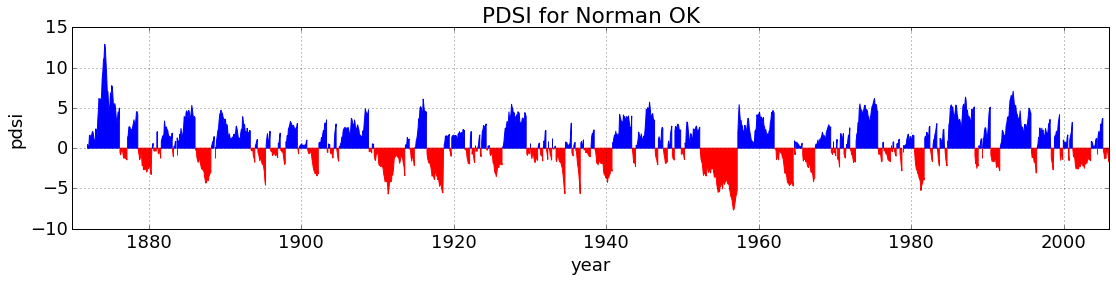

In [44]:
title="PDSI for "+where
units='pdsi'
tsp = time_series_plot(tvalys, pointpdsi, title=title, ylab=units,xlab='year',negc='red',posc='blue')
tsp

In [45]:
whr = where.replace(' ','')
whr = whr.replace(',','')
outname = "PDSI_"+whr+'.png'
print("will save to:",outname)

will save to: PDSI_NormanOK.png


In [46]:
tsp.savefig(outname)

# Correlation of PDSI with the chosen point

We make a time series with a time-step of one year: all the months of March.
There are certainly other possibilities, such as examining other months. But there are no tasks assigned here for changing the month.


In [47]:
dates[2] # 2 is the 3rd month, March

datetime.datetime(1870, 3, 1, 0, 0)

In [48]:
pdsi_March = pdsi[2::12] # 2 is the first March, then skip every 12 months

In [49]:
# Make a short variable name
v = pdsi_March.copy()
vmean = v.mean(0) #mean along first axis, time
v = v - vmean 

In [50]:
vp = v[:,pointlati,pointloni] # time series at the chosen point

In [51]:
vp.shape # 136 values for March

(136,)

In [52]:
v.shape

(136, 55, 144)

`.T` means *transpose*, which puts the time index last:

In [53]:
v.T.shape

(144, 55, 136)

`v.T*vp` is succesful below. Every March pdsi at a point is multiplied by the value at Norman (or other chosen point) at that time.

In [54]:
vvp = (v.T*vp).T # Tranpose back, to put time index first again

In [55]:
vcorr = vvp.mean(0)/np.sqrt( (v*v).mean(0) * (vp*vp).mean(0) ) # correlation coefficient

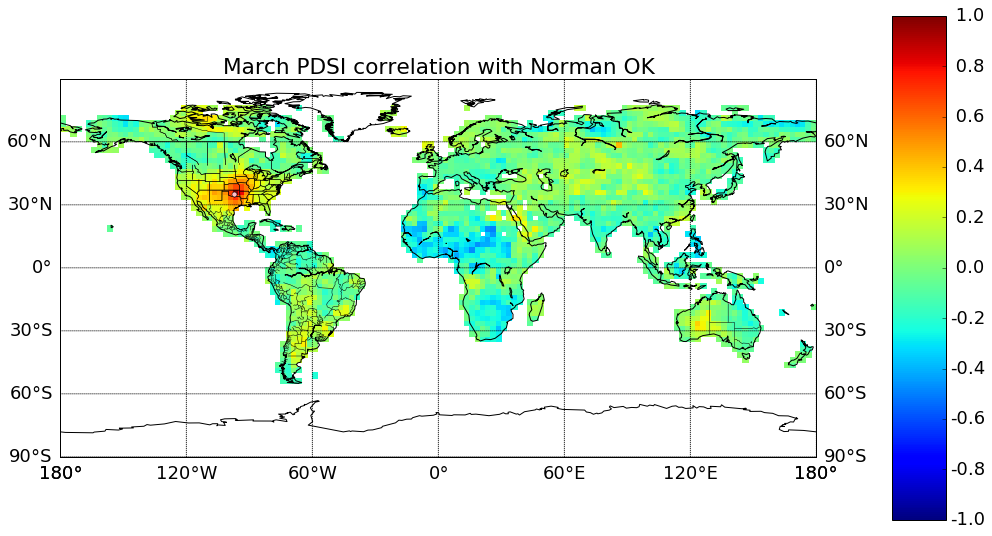

In [56]:
#Plot the correlation coefficient
colormap = plt.cm.jet
colorbounds=[-1,1]
fig = plt.figure(figsize=(15,10))

ax = fig.add_axes([0.08,0.1,0.7,0.7],axisbg='white')

p = m.pcolormesh(X, Y, vcorr, cmap=colormap) # colorize area around data point
m.drawcoastlines()
m.drawstates()

im = plt.gci() # these two statement map extreme colors out chosen numbers
im.set_clim(vmin=colorbounds[0],vmax=colorbounds[1]) 

cax = fig.add_axes([0.85, 0.1, 0.05, 0.7]) # setup colorbar axes

plt.colorbar(format='%4.1f', cax=cax) # draw colorbar

plt.axes(ax)  # make the original axes current again

xpt,ypt=m(pointlon,pointlat)
m.plot([xpt],[ypt],'o',color='pink',markersize=5,zorder=2) 

ax.set_title("March PDSI correlation with "+where)
m.drawparallels(parallels,labels=[1,1,0,1])
m.drawmeridians(meridians,labels=[1,1,0,1]);

In [57]:
outname = "corr"+whr+".png"
print(outname)
fig.savefig(outname)

corrNormanOK.png


<hr style="height:6px;border:none;background-color:#f00;" />

# Student Tasks
 * The plots for `knmi/ilabrijn.nc` are a bit crowded until we filter the data a bit. Plot only the January temperatures.
 
 <img src="http://metr4330.net/img/TdebiltJanuaryX.png">
 
 * Plot and post the "March PDSI correlation with Toowoomba"
 * Complete the Autocorrelation task below:

## Autocorrelation

[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation).

This is what you are shooting for:

<img src="http://metr4330.net/img/corrauto12monthX.png">

Produce and post a 3 month, 12 month and 36 month autocorrelation plot.

In [58]:
lag = 12 # number of months to lag by

In [59]:
# I will give you a start:
v1 = pdsi[lag:]
v2 = pdsi[:-lag]
v1 = v1 - v1.mean(0)
v2 = v2 - v2.mean(0)


In [60]:
outname = "corrauto%dmonth.png" % lag
print(outname)
figa.savefig(outname)

corrauto12month.png


NameError: name 'figa' is not defined